# How To Make Spectrograms from EEG
In this notebook, we learn how to make spectrograms from EEG. The EEGs are waveforms and the Spectrograms are images. There is a discussion about this notebook [here][1].

In version 1-3, we also train a simple model using our EEG spectrograms to confirm that they work well. We observe that a model trained with EEG spectrograms performs better than baseline models using only train means.

# Exciting UPDATE!
Version 4 of this notebook uses a different formula to make spectrograms than earlier versions. I trained an EfficientNet model using the old version eeg spectrograms, new version spectrograms, and Kaggle spectrograms. We can see that the new version eeg spectrograms are **powerful**!

| Spectrogram | 5-Fold CV | LB |
| --- | --- | --- |
| Kaggle spectrogram | 0.73 | 0.57 |
| Old EEG formula | 0.84 on fold 1 | ?? |
| New EEG formula | 0.70 on fold 1| ?? |
| Use both Kaggle and New | 0.64 | 0.44 |

From the results above, we conclude that our new formula is probably similar or better than the true formula used to create the Kaggle spectrograms. Details about the old and new formula are in the next notebook section. 

# How To Use EEG Spectrograms
Examples of how to use new EEG spectrograms to boost CV score and LB score will be (or already are) published in recent versions of my EfficientNet starter notebook [here][2] and CatBoost starter notebook [here][3]

# Kaggle Dataset
The new EEG spectrograms from version 4 of this notebook have been uploaded to a Kaggle dataset [here][4]. We can attach this Kaggle dataset to our future notebooks to boost our CV scores and LB scores! Thank you everyone for upvoting my new EEG spectrogram Kaggle dataset!

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[2]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57
[3]: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67
[4]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms

In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

train = pd.read_csv('data/train.csv')
print('Train shape', train.shape )
display( train.head() )

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# The Bipolar Double Banana Montage
In the Kaggle discussion [here][1], we learn what information we need to make spectrograms from eegs. The following website [here][2] is helpful also. To build 1 spectrogram, we need 1 time series signal. Kaggle provides us with 19 eeg time signals, so we must combine them into 4 time signals to make 4 spectrograms.

In the diagram below, we see which electrode signals are needed to make the `LL, LP, RP, RR` spectrograms. Furthermore Kaggle discussions imply that most likely we create differences between consecutive electrodes and average the differences. For example, we create `LL spectrogram` with the formula: 

    LL = ( (Fp1 - F7) + (F7 - T3) + (T3 - T5) + (T5 - O1) )/4.
    
I am not positive that this is the correct formula. I also tried the formula below but it produced a worse CV score than the above formula, so perhaps the above is correct. I am confident that we only use these 5 electrodes to create `LL spectrogram`. I'm just a little unsure about the formula:

    LL = ( Fp1 + F7 + T3 + T5 + O1 )/5.
    
# Exciting UPDATE!
I believe the above two formulas are wrong. Many Kagglers have pointed out that the above formula reduces to `LL = ( Fp1 - O1 )/4` which means that it does not use all the EEG signals. The new formula below utilizes all the EEG signals and produces EEG spectrograms that achieve better CV score and LB score than the Kaggle spectrograms. Therefore I think the following formula is the correct one:

    LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4.
    
Since creating a spectrogram is a non-linear operation, the above formula which computes 4 spectrograms and then takes the average is different than the formula below which computes 1 spectrogam. And the above formula does utilize all EEG signals and cannot be reduced to a shorter formula (like the one below).

    LL Spec = spec( ( (Fp1 - F7) + (F7 - T3) + (T3 - T5) + (T5 - O1) )/4. )

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/montage.png)

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[2]: https://www.learningeeg.com/montages-and-technical-components

In [2]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

directory_path = 'EEG_Scalograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Optional Signal Denoising with Wavelet transform
We can optionally denoise the signal before creating the spectrogram. I'm not sure yet if this creates better or worse spectrograms. We can experiment with this. This code comes from Yusaku5738 notebook [here][1] and was suggested by SeshuRajuP in the comments. We have many parent functions to use for denoising. Yusaku5738 suggests using `wavelet = db8`.

[1]: https://www.kaggle.com/code/yusaku5739/eeg-signal-denosing-using-wavelet-transform

In [3]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = None #or "db8" or anything below

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [4]:
# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

# CWT Module

In [5]:
# From https://github.com/tomrunia/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py

## from G2net1 
import torch
from scipy import signal
from scipy import optimize
import torch.nn as nn
from timm.layers.conv2d_same import conv2d_same

class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s


class CWT(nn.Module):
    def __init__(
        self,
        dj=0.0625,
        dt=1 / 200,
        wavelet=Morlet(),
        fmin: int = 20,
        fmax: int = 500,
        output_format="Magnitude",
        trainable=False,
        hop_length: int = 1,
    ):
        super().__init__()
        self.wavelet = wavelet

        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable  # TODO make kernel a trainable parameter
        self.stride = (1, hop_length)
        # self.padding = 0  # "same"

        self._scale_minimum = self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None

        self._scales = None
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        """
        Determines the optimal scale distribution (see. Torrence & Combo, Eq. 9-10).
        :return: np.ndarray, collection of scales
        """
        if self.signal_length is None:
            raise ValueError(
                "Please specify signal_length before computing optimal scales."
            )
        J = int(
            (1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2 ** (self.dj * np.arange(0, J + 1))

        # Remove high and low frequencies
        frequencies = np.array([1 / self.wavelet.fourier_period(s) for s in scales])
        if self.fmin:
            frequencies = frequencies[frequencies >= self.fmin]
            scales = scales[0 : len(frequencies)]
        if self.fmax:
            frequencies = frequencies[frequencies <= self.fmax]
            scales = scales[len(scales) - len(frequencies) : len(scales)]

        return scales

    def compute_minimum_scale(self):
        """
        Choose s0 so that the equivalent Fourier period is 2 * dt.
        See Torrence & Combo Sections 3f and 3h.
        :return: float, minimum scale level
        """
        dt = self.dt

        def func_to_solve(s):
            return self.wavelet.fourier_period(s) - 2 * dt

        return optimize.fsolve(func_to_solve, 1)[0]

    def _build_filters(self):
        self._filters = []
        for scale_idx, scale in enumerate(self._scales):
            # Number of points needed to capture wavelet
            M = 10 * scale / self.dt
            # Times to use, centred at zero
            t = torch.arange((-M + 1) / 2.0, (M + 1) / 2.0) * self.dt
            if len(t) % 2 == 0:
                t = t[0:-1]  # requires odd filter size
            # Sample wavelet and normalise
            norm = (self.dt / scale) ** 0.5
            filter_ = norm * self.wavelet(t, scale)
            self._filters.append(torch.conj(torch.flip(filter_, [-1])))

        self._pad_filters()

    def _pad_filters(self):
        filter_len = self._filters[-1].shape[0]
        padded_filters = []

        for f in self._filters:
            pad = (filter_len - f.shape[0]) // 2
            padded_filters.append(nn.functional.pad(f, (pad, pad)))

        self._filters = padded_filters

    def _build_wavelet_bank(self):
        """This function builds a 2D wavelet filter using wavelets at different scales

        Returns:
            tensor: Tensor of shape (num_widths, 1, channels, filter_len)
        """
        self._build_filters()
        wavelet_bank = torch.stack(self._filters)
        wavelet_bank = wavelet_bank.view(
            wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
        )
        # See comment by tez6c32
        # https://www.kaggle.com/anjum48/continuous-wavelet-transform-cwt-in-pytorch/comments#1499878
        # wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        return wavelet_bank

    def forward(self, x):
        """Compute CWT arrays from a batch of multi-channel inputs

        Args:
            x (torch.tensor): Tensor of shape (batch_size, channels, time)

        Returns:
            torch.tensor: Tensor of shape (batch_size, channels, widths, time)
        """
        if self.signal_length is None:
            self.signal_length = x.shape[-1]
            self.channels = x.shape[-2]
            self._scales = self.compute_optimal_scales()
            self._kernel = self._build_wavelet_bank()

            if self._kernel.is_complex():
                self._kernel_real = self._kernel.real
                self._kernel_imag = self._kernel.imag

        x = x.unsqueeze(1)
        if self._kernel.is_complex():
            if (
                x.dtype != self._kernel_real.dtype
                or x.device != self._kernel_real.device
            ):
                self._kernel_real = self._kernel_real.to(device=x.device, dtype=x.dtype)
                self._kernel_imag = self._kernel_imag.to(device=x.device, dtype=x.dtype)

            # Strides > 1 not yet supported for "same" padding
            # output_real = nn.functional.conv2d(
            #     x, self._kernel_real, padding=self.padding, stride=self.stride
            # )
            # output_imag = nn.functional.conv2d(
            #     x, self._kernel_imag, padding=self.padding, stride=self.stride
            # )
            output_real = conv2d_same(x, self._kernel_real, stride=self.stride)
            output_imag = conv2d_same(x, self._kernel_imag, stride=self.stride)
            output_real = torch.transpose(output_real, 1, 2)
            output_imag = torch.transpose(output_imag, 1, 2)

            if self.output_format == "Magnitude":
                return torch.sqrt(output_real ** 2 + output_imag ** 2)
            else:
                return torch.stack([output_real, output_imag], -1)

        else:
            if x.device != self._kernel.device:
                self._kernel = self._kernel.to(device=x.device, dtype=x.dtype)

            # output = nn.functional.conv2d(
            #     x, self._kernel, padding=self.padding, stride=self.stride
            # )
            output = conv2d_same(x, self._kernel, stride=self.stride)
            return torch.transpose(output, 1, 2)

# Create Spectrograms with Librosa
We can use library librosa to create spectrograms. We will save them to disk. For each `eeg_id` we will make 1 spectrogram from the middle 50 seconds. We don't want to use more information than 50 seconds at a time because during test inference, we only have access to 50 seconds of EEG for each test `eeg_id`. We will create spectrograms of `size = 128x256 (freq x time)`.

The main function is 

    mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
              n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)
              
Let's explain these variables.
* `y` is the input time series signal
* `sr` is the sampling frequency. In this competition EEG is sample 200 times per sec
* `hop_length` produces image with `width = len(x)/hop_length`
* `n_fft` controls vertical resolution and quality of spectrogram
* `n_mels` produces image with `height = n_mels`
* `fmin` is smallest frequency in our spectrogram
* `fmax` is largest frequency in our spectrogram
* `win_length` controls hortizonal resolution and quality of spectrogram

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pycwt = CWT(fmin=0, fmax=25, hop_length=20, dj=0.0405).to(device)

In [8]:
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((256,512,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(len(COLS)-1):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
                
            x /= np.max(np.maximum(np.abs(x), 0.01))
            
            S = torch.tensor(x)[None,:].to(device)
            if device=='cuda:0':
                out = pycwt(S).cpu().numpy()
            else:
                out = pycwt(S).numpy()
            
            #print(out.shape)
            
            out1 = librosa.power_to_db(out, ref=np.max).astype(np.float32)
            out1 = (out1+40)/40 
            img[:-1,6:-6,k] +=out1[:,:,0]
            
            signals.append(x)

#             # RAW SPECTROGRAM
#             mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
#                   n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

#             # LOG TRANSFORM
#             width = (mel_spec.shape[1]//32)*32
#             mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

#             # STANDARDIZE TO -1 TO 1
#             mel_spec_db = (mel_spec_db+40)/40 
#             img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= (len(COLS)-1)
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

  0%|          | 0/17089 [00:00<?, ?it/s]

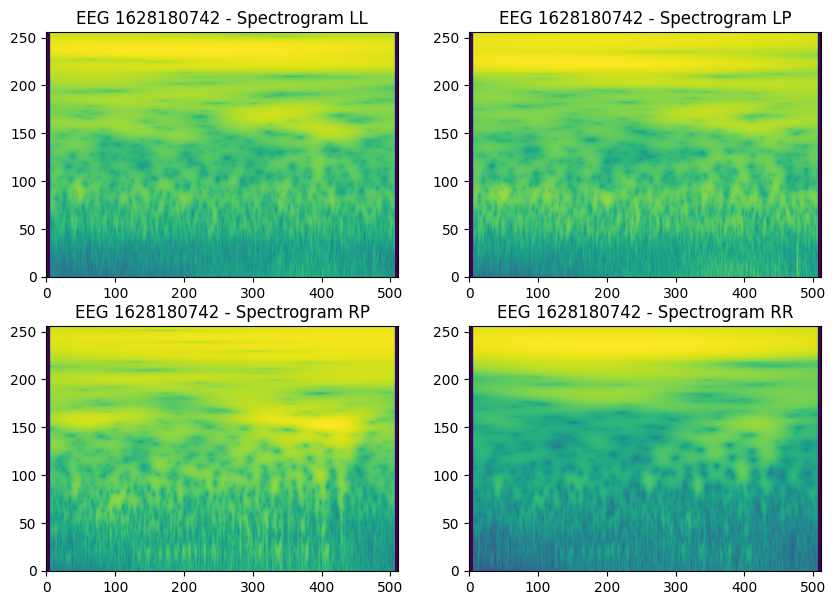

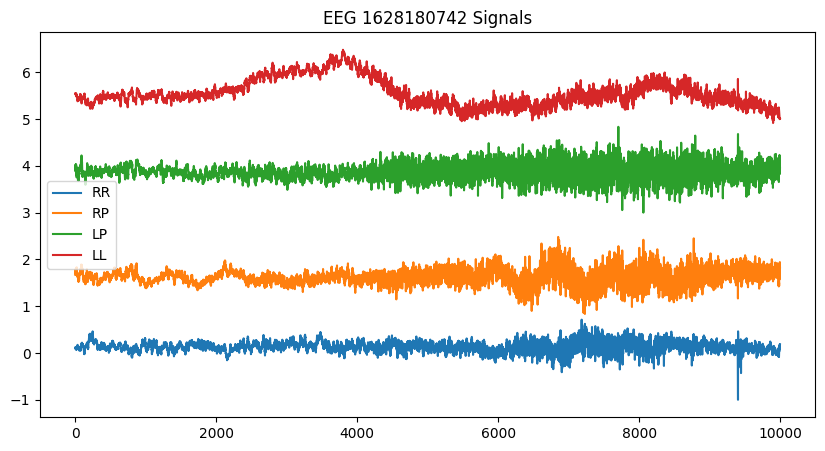

  0%|          | 1/17089 [00:07<36:34:11,  7.70s/it]


#########################



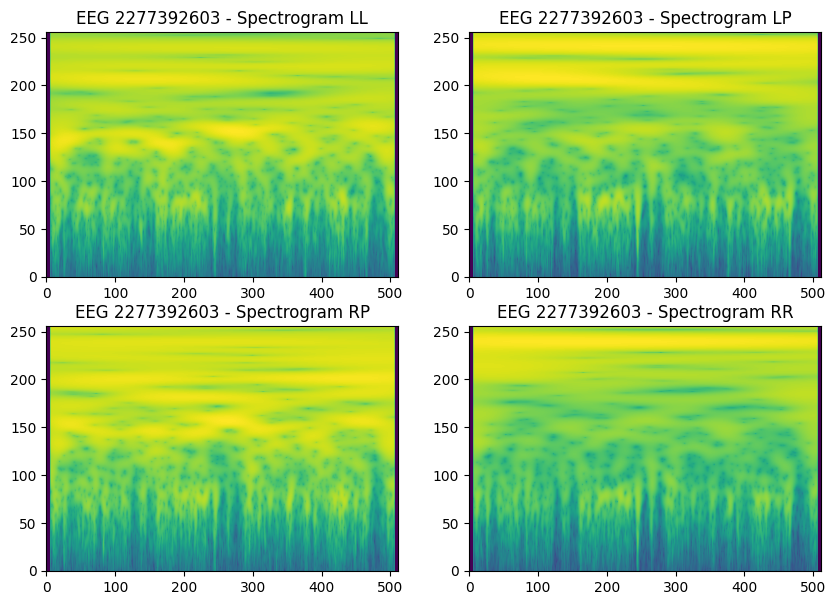

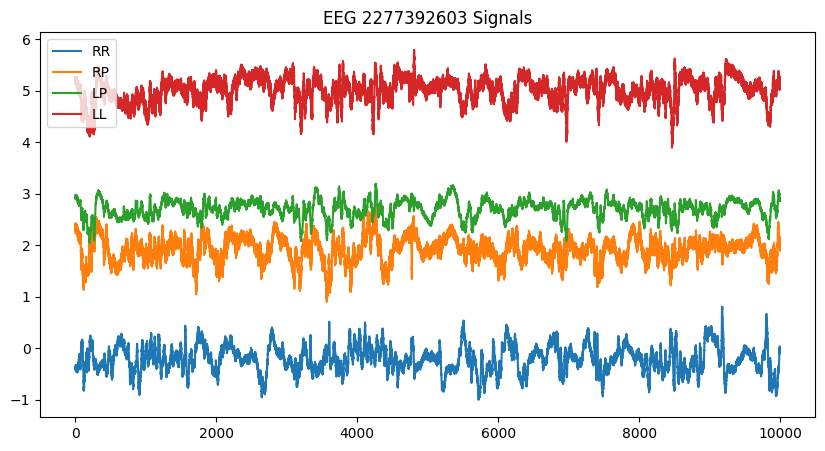

  0%|          | 2/17089 [00:10<23:57:10,  5.05s/it]


#########################



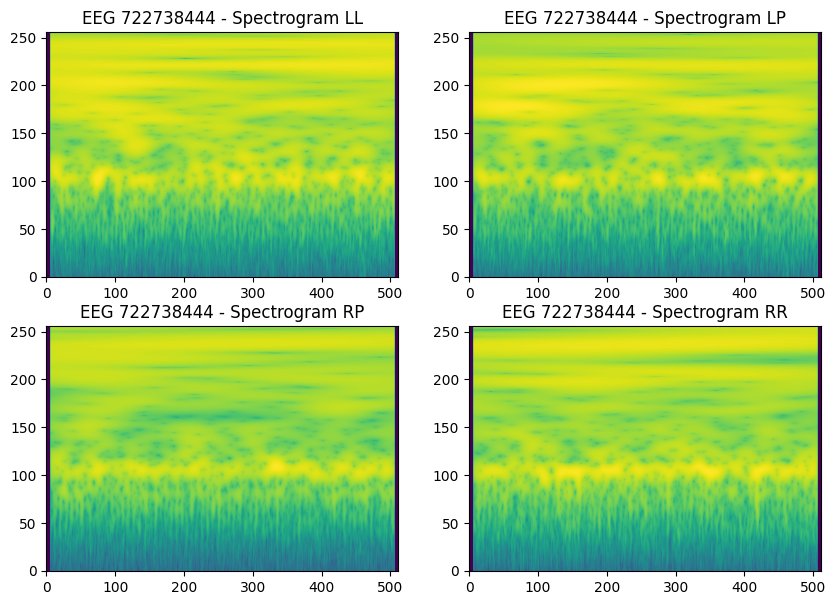

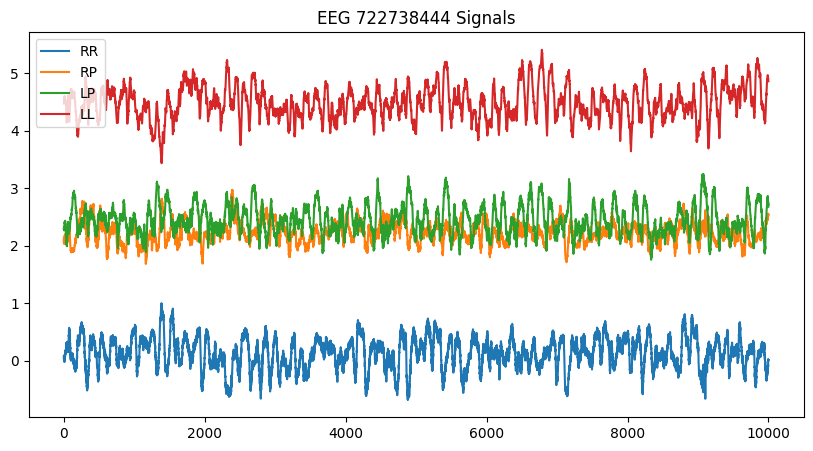

  0%|          | 3/17089 [00:12<15:38:54,  3.30s/it]


#########################



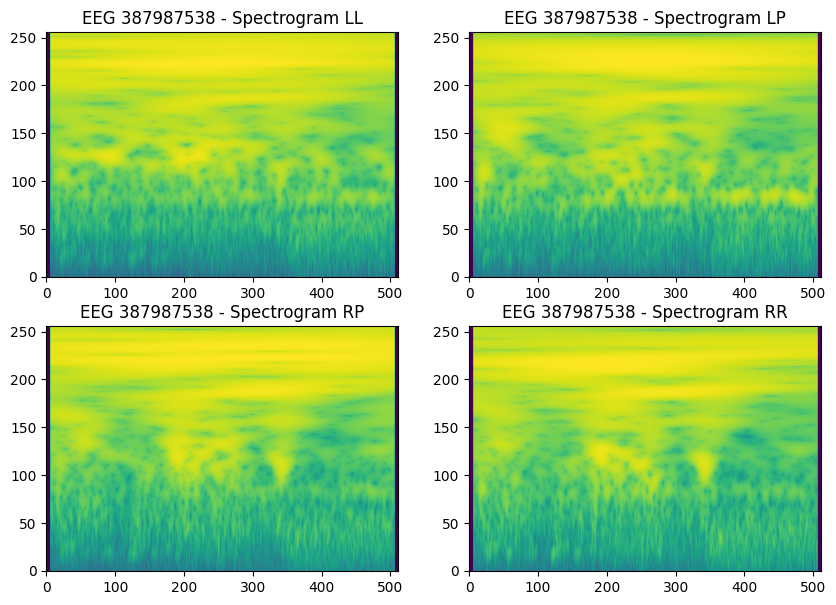

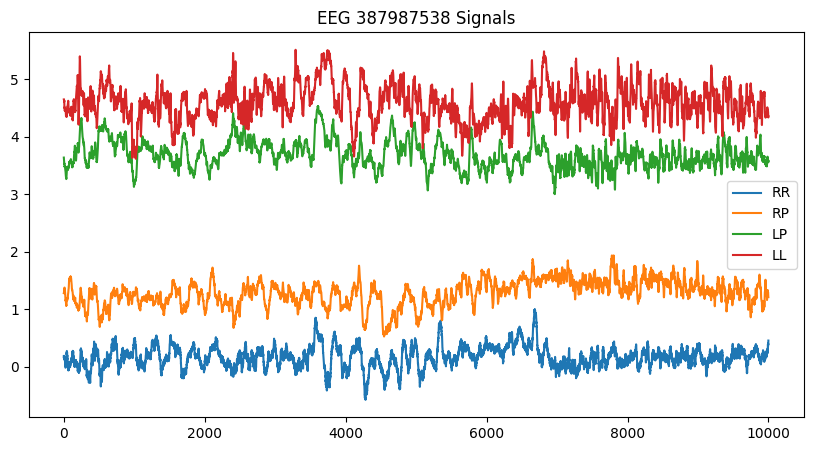

  0%|          | 4/17089 [00:13<11:37:48,  2.45s/it]


#########################



  0%|          | 5/17089 [00:13<8:05:23,  1.70s/it] 

Creating and writing 17089 spectrograms to disk... 

100%|██████████| 17089/17089 [2:00:44<00:00,  2.36it/s]  


CPU times: user 1h 15min 9s, sys: 4min 18s, total: 1h 19min 28s
Wall time: 2h 10min 55s


In [9]:
%%time
PATH = 'data/train_eegs/'
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
all_eegs = {}

from tqdm import tqdm

for i,eeg_id in enumerate(tqdm(EEG_IDS)):
    #if (i%100==0)&(i!=0): print(i,', ',end='')
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')
    #np.save(f'{directory_path}{eeg_id}',img)
    all_eegs[eeg_id] = img
   
# SAVE EEG SPECTROGRAM DICTIONARY
np.save('data/eeg_spectrograms/eeg_scalos_256x512',all_eegs)

# Kaggle Dataset
The new EEG spectrograms from version 4 of this notebook have been uploaded to a Kaggle dataset [here][4]. We can attach this Kaggle dataset to our future notebooks to boost our CV scores and LB scores! Thank you everyone for upvoting my new EEG spectrogram Kaggle dataset!

Examples of how to use EEG spectrograms to boost CV score and LB score will be (or already are) published in recent versions of my EfficientNet starter notebook [here][2] and CatBoost starter notebook [here][3]

Enjoy! Happy Kaggling!

[2]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57
[3]: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67
[4]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms